## <small>
Copyright (c) 2017-21 Andrew Glassner

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</small>



# Deep Learning: A Visual Approach
## by Andrew Glassner, https://glassner.com
### Order: https://nostarch.com/deep-learning-visual-approach
### GitHub: https://github.com/blueberrymusic
------

### What's in this notebook

This notebook is provided as a “behind-the-scenes” look at code used to make some of the figures in this chapter. It is cleaned up a bit from the original code that I hacked together, and is only lightly commented. I wrote the code to be easy to interpret and understand, even for those who are new to Python. I tried never to be clever or even more efficient at the cost of being harder to understand. The code is in Python3, using the versions of libraries as of April 2021. 

This notebook may contain additional code to create models and images not in the book. That material is included here to demonstrate additional techniques.

Note that I've included the output cells in this saved notebook, but Jupyter doesn't save the variables or data that were used to generate them. To recreate any cell's output, evaluate all the cells from the start up to that cell. A convenient way to experiment is to first choose "Restart & Run All" from the Kernel menu, so that everything's been defined and is up to date. Then you can experiment using the variables, data, functions, and other stuff defined in this notebook.

## Chapter 19: RNNs - Notebook 6: Novels

This notebook is mostly about making the figures for generating text. There are a couple of additional figures for predicting data from curves, which are redundant with similar plots in Chapter 19, Notebook 5.

## A note on consistency

Due to the use of random numbers, each time you run this notebook you'll get
different results. 
 

In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, LeakyReLU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import math
import seaborn as sns ; sns.set()

random_seed = 42

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
# Workaround for Keras issues on Mac computers (you can comment this
# out if you're not on a Mac, or not having problems)
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
def sum_of_mixed_sines(num_steps):
    values = [math.sin(12*t) * math.cos(t) + (math.sin(3*t) * math.sin(t/2.3)) \
              for t in np.linspace(0, 4 * np.pi, num_steps)]
    return np.array(values)

In [3]:
def get_sunspot_data():
    filename = 'data/Sunspots.txt'
    with open(filename) as f:
        content = f.readlines()
    data = [float(x.strip()) for x in content] 
    data = np.array(data)
    return data

In [4]:
import string
def get_book(): 
    # get starting six chapters of A Tale of Two Cities, from Project Gutenberg
    # https://www.gutenberg.org/ebooks/98
    word_to_index = {}
    index_to_word = {}
    current_index = 0
    book_indices = []
    filename = 'data/twocities-book1.txt'
    fp = open(filename, 'r')
    for line in fp:
        sline = line.strip()
        words = sline.split()
        for word in words:
            strip_word = word.strip().lower()
            strip_word = ''.join(ch for ch in strip_word if ch not in string.punctuation)
            if strip_word not in word_to_index:
                word_to_index[strip_word] = current_index
                index_to_word[current_index] = strip_word
                current_index += 1
            book_indices.append(word_to_index[strip_word])
    fp.close()
    book_indices = np.array(book_indices)
    
    return [word_to_index, index_to_word, book_indices]

In [5]:
def make_raw_data(training_length, test_length, data_source):
    if data_source == 'sines':
        X_train = sum_of_mixed_sines(training_length)
        X_test = sum_of_mixed_sines(test_length)
    elif data_source == 'spots':
        data = get_sunspot_data()
        train_len = int(len(data) * training_length / (training_length + test_length))
        train_len = 2752
        X_train = data[:train_len]
        X_test = data[train_len:]
    elif data_source == 'book':
        word_to_index, index_to_word, book_indices = get_book()
        data = book_indices
        train_len = int(.7 * len(data))
        X_train = data[:train_len]
        X_test = data[train_len:]
    else:
        raise Exception('UNKNOWN DATA SOURCE')
        exit()
    print('X_train.shape=',X_train.shape, ' X_test.shape=',X_test.shape)
    return (X_train, X_test)

In [6]:
def samples_and_targets_from_sequence(sequence, window_size):
    '''Return lists of samples and targets built from overlapping
    windows of the given size. Windows start at the beginning of 
    the input sequence and move right by 1 element.'''
    samples = []
    targets = []
    for i in range(sequence.shape[0]-window_size):
        sample = sequence[i:i+window_size]
        target = sequence[i+window_size]
        samples.append(sample)
        targets.append(target[0]) 
    return (np.array(samples), np.array(targets))

In [7]:
def scale_sequences(training_sequence, test_sequence):
    # reshape train and test sequences to form needed by MinMaxScaler
    training_sequence = np.reshape(training_sequence, (training_sequence.shape[0], 1))
    test_sequence = np.reshape(test_sequence, (test_sequence.shape[0], 1))
    min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
    min_max_scaler.fit(training_sequence)
    scaled_training_sequence = min_max_scaler.transform(training_sequence)
    scaled_test_sequence = min_max_scaler.transform(test_sequence)
    return (min_max_scaler, scaled_training_sequence, scaled_test_sequence)

In [8]:
def chop_up_sequences(training_sequence, test_sequence, window_size):
    (X_train, y_train) = samples_and_targets_from_sequence(training_sequence, window_size)
    (X_test, y_test) = samples_and_targets_from_sequence(test_sequence, window_size)
    return (X_train, y_train, X_test, y_test)

In [9]:
def make_data_set(window_size, training_length, data_source):
    testing_length = 0.5 * training_length
    train_seq, test_seq = make_raw_data(training_length, testing_length, data_source)
    min_max_scaler, scaled_train_seq, scaled_test_seq = scale_sequences(train_seq, test_seq)
    X_train, y_train, X_test, y_test = chop_up_sequences(scaled_train_seq, scaled_test_seq, window_size)
    return (min_max_scaler, X_train, y_train, X_test, y_test, train_seq, test_seq)

In [10]:
def plot_one_curve(data, title, linewidth=2, filename=None):
    plt.figure(figsize=(8,3))
    plt.plot(data, lw=linewidth)
    #plt.title(title)
    if filename is not None:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

X_train.shape= (500,)  X_test.shape= (200,)


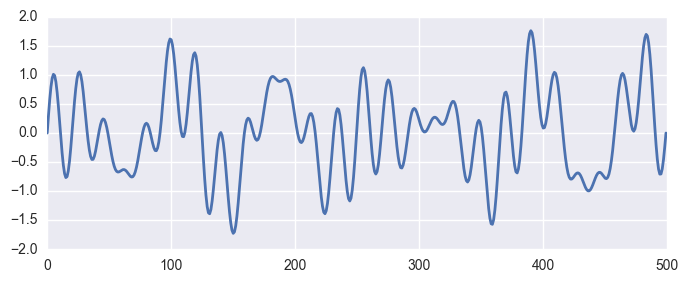

In [13]:
X_train, X_test = make_raw_data(500, 200, 'sines')
plt.figure(figsize=(8,3))
plt.plot(X_train, lw=2)
plt.savefig("sine-wave-data.png", dpi=300, bbox_inches='tight')
plt.show()

X_train.shape= (2752,)  X_test.shape= (500,)


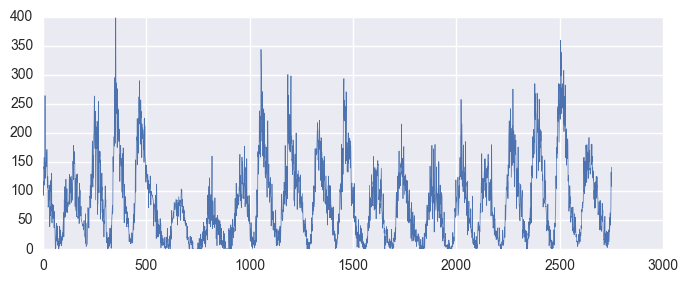

In [12]:
X_train, X_test = make_raw_data(500, 200, 'spots')
plot_one_curve(X_train, 'Raw training data', 0.5, 'spots_raw_training_data.png')

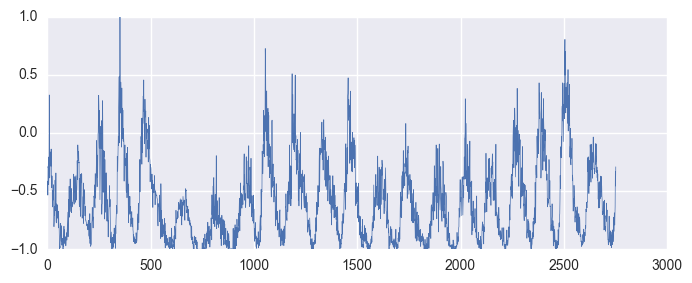

In [13]:
mmscaler, tr, te = scale_sequences(X_train, X_test)
plot_one_curve(tr, 'Normalized training data', 0.5, 'spots_normalized_training_data.png')

In [10]:
# build and run the first model. 
def make_rnn_model(units_list, window_size):
    model = Sequential()
    for i, num_units in enumerate(units_list):
        if i == 0:
            ret_seq = len(units_list) > 1
            model.add(LSTM(num_units, return_sequences = ret_seq, input_shape=[window_size, 1]))
        else:
            ret_seq = i != len(units_list)-1
            model.add(LSTM(num_units, return_sequences = ret_seq))

    model.add(Dense(1, activation=None))

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [11]:
def make_dense_model(units_list, window_size):
    model = Sequential()
    for i in range(len(units_list)):
        activation = 'relu'
        if i == len(units_list)-1:
            activation = 'linear'  # last activation is linear
        if i==0:
            model.add(Dense(units_list[i], activation=activation, input_shape=[window_size]))
        else:
            model.add(Dense(units_list[i], activation=activation))
        model.add(LeakyReLU(alpha=0.1))   
    model.add(Dense(1))

    model.compile(loss='mse', optimizer=RMSprop(0.001), metrics=['accuracy', 'mae', 'mse'])
    model.summary()
    return model

In [18]:
def build_and_show(model_type, data_source, units_list, window_size, training_length, 
                   epochs, linewidth=2, filename=None, tight_x_limits=False):
    np.random.seed(random_seed)
    min_max_scaler, X_train, y_train, X_test, y_test, train_data, test_data = \
        make_data_set(window_size, training_length, data_source)
    if model_type == 'RNN':
        model = make_rnn_model(units_list, window_size)
    else:
        model = make_dense_model(units_list, window_size)
        # data is made for RNN, so reshape
        X_train = np.reshape(X_train, X_train.shape[0:2])
        X_test = np.reshape(X_test, X_test.shape[0:2])
        
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, min_delta=.001)
    history = model.fit(X_train, y_train, validation_split=0.33, epochs=epochs, batch_size=1, verbose=1, callbacks=[es])
    
    # Predict 
    y_train_predict = np.ravel(model.predict(X_train))
    y_test_predict = np.ravel(model.predict(X_test))
    
    # invert transformation
    inverse_y_train_predict = min_max_scaler.inverse_transform([y_train_predict])
    inverse_y_test_predict = min_max_scaler.inverse_transform([y_test_predict])  
    
    model_string = model_type+' '+str(units_list)
    
    plt.figure(figsize=(6,6))
    plt.plot(history.history['loss'], c='#c04f54', label='training loss')
    plt.plot(history.history['val_loss'], c='#5ca66a', label='validation loss')
    #plt.title('Training loss, model '+model_string)
    plt.legend(loc='best')
    if filename is not None:
        plt.savefig('loss-'+filename, dpi=300, bbox_inches='tight')
    plt.show()
       
    plt.figure(figsize=(12, 4))
    
    zfar = 10
    znear = 20
    blue_color = '#4d74ae'
    orange_color = '#f6712a'
    
    plt.subplot(1, 2, 1)
    plt.plot(train_data, label="train", c=blue_color, linewidth=linewidth, zorder=zfar)
    skip_values = np.array(window_size*(np.nan,))
    flat_predict = np.ravel(inverse_y_train_predict)
    plot_predict = np.append(skip_values, flat_predict)
    if tight_x_limits:
        plt.xlim(0, max(len(train_data), len(plot_predict)))
    plt.plot(plot_predict, label="train predict", c=orange_color, linewidth=linewidth, zorder=znear)
    plt.legend(loc='best')
    #plt.title('Train, window '+str(window_size)+ ', model '+model_string)    
    
    plt.subplot(1, 2, 2)
    plt.plot(test_data, label="test", c=blue_color, linewidth=linewidth, zorder=zfar)
    skip_values = np.array(window_size*(np.nan,))
    flat_predict = np.ravel(inverse_y_test_predict)
    plot_predict = np.append(skip_values, flat_predict)
    if tight_x_limits:
        plt.xlim(0, max(len(test_data), len(plot_predict)))
    plt.plot(plot_predict, label="test predict", c=orange_color, linewidth=linewidth, zorder=znear)
    plt.legend(loc='best')
    #plt.title('Test, window '+str(window_size)+ ', model '+model_string) 
    
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    return [inverse_y_train_predict, inverse_y_test_predict]

In [17]:
# WARNING! This makes a ton of plots. It will take a long time to run!
# To train up just one case, call build_and_show() with just the options you want

def make_all_plots():
    sines_num_epochs = 50 # Early stopping will usually bring a halt to this a lot sooner
    spots_num_epochs = 200
    book_num_epochs = 50

    sines_training_length = 500
    spots_training_length = 2332
    book_training_length = 17267

    sines_model_shapes = [[3], [3,3], [3,3,3,3,3], [5], [5,5], [5,5,5,5,5], [10], [10,10], [10,10,10,10,10], [25], [25,25], [25,25,25,25,25]]
    spots_model_shapes = [[3], [3,3], [3,3,3], [5], [5,5], [4, 2, 1], [256, 128, 32]]
    book_model_shapes = [[3], [3,3], [3,3,3], [5], [5,5], [4, 2, 1], [256, 128, 32]]

    sines_windows = [5, 10, 20]
    spots_windows = [5, 50, 100, 200] 
    book_windows = [5, 50, 100, 200] 

    sines_linewidth = 2
    spots_linewidth = 1
    book_linewidth = 1

    for data_source in ['sines', 'spots', 'book']:
        num_epochs = sines_num_epochs
        training_length = sines_training_length
        model_shapes = sines_model_shapes
        windows = sines_windows
        linewidth = sines_linewidth
        if data_source == 'spots':
            num_epochs = spots_num_epochs
            training_length = spots_training_length
            model_shapes = spots_model_shapes
            windows = spots_windows
            linewidth = spots_linewidth
        elif data_source == 'book':
            num_epochs = book_num_epochs
            training_length = book_training_length
            model_shapes = book_model_shapes
            windows = book_windows
            linewidth = book_linewidth

        for units_list in model_shapes:
            for window_size in windows:
                for model_type in ['RNN', 'Dense']:
                    filename = data_source+'-'+model_type+'-units-'+str(units_list)+'-window-'+str(window_size)+'.png'
                    build_and_show(model_type, data_source, units_list=units_list, window_size=window_size, 
                                   training_length=training_length, epochs=num_epochs, 
                                   linewidth=linewidth, filename=filename)

X_train.shape= (12086,)  X_test.shape= (5181,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 5)                 30        
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 5)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 6         
Total params: 36
Trainable params: 36
Non-trainable params: 0
_________________________________________________________________


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


Train on 8094 samples, validate on 3987 samples
Epoch 1/8
8094/8094 [==============================] - 6s 772us/step - loss: 0.1817 - acc: 0.0103 - mean_absolute_error: 0.3408 - mean_squared_error: 0.1817 - val_loss: 0.5528 - val_acc: 0.0080 - val_mean_absolute_error: 0.6031 - val_mean_squared_error: 0.5528
Epoch 2/8
8094/8094 [==============================] - 6s 757us/step - loss: 0.1595 - acc: 0.0116 - mean_absolute_error: 0.3226 - mean_squared_error: 0.1595 - val_loss: 0.5540 - val_acc: 0.0095 - val_mean_absolute_error: 0.5948 - val_mean_squared_error: 0.5540
Epoch 3/8
8094/8094 [==============================] - 6s 759us/step - loss: 0.1587 - acc: 0.0112 - mean_absolute_error: 0.3221 - mean_squared_error: 0.1587 - val_loss: 0.5428 - val_acc: 0.0098 - val_mean_absolute_error: 0.5879 - val_mean_squared_error: 0.5428
Epoch 4/8
8094/8094 [==============================] - 6s 762us/step - loss: 0.1585 - acc: 0.0114 - mean_absolute_error: 0.3223 - mean_squared_error: 0.1585 - val_loss: 

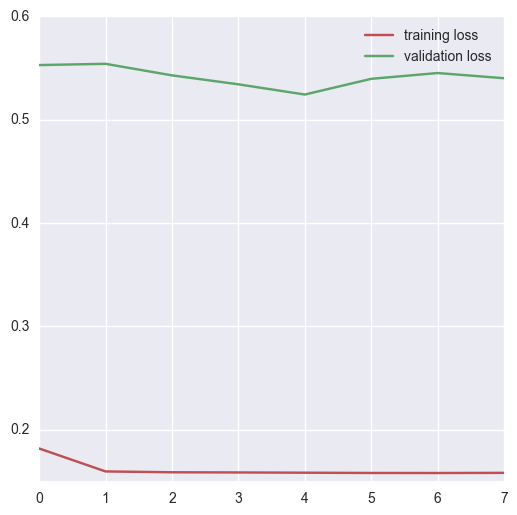

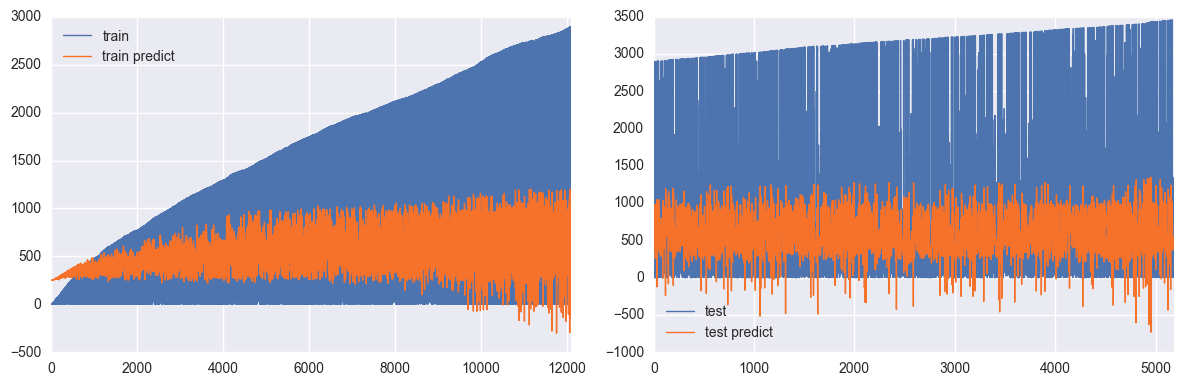

In [19]:
# Make only the plot showing the book overview
def make_book_overview_plot():

    num_epochs = 8
    training_length = 17267
    model_shape = [5]
    window_size = 5
    linewidth = 1

    filename = 'book-pair-5.png'
    build_and_show('Dense', 'book', units_list=model_shape, window_size=window_size, 
                   training_length=training_length, epochs=num_epochs, 
                   linewidth=linewidth, filename=filename, tight_x_limits=True)
                    
make_book_overview_plot()

In [18]:
# This makes a TON of plots. Some training sequences are slow. Let this be an overnight thing.
#make_all_plots()

X_train.shape= (12086,)  X_test.shape= (5181,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5)                 30        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 5)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 36
Trainable params: 36
Non-trainable params: 0
_________________________________________________________________


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


Train on 8094 samples, validate on 3987 samples
Epoch 1/50
8094/8094 [==============================] - 6s 759us/step - loss: 0.1817 - acc: 0.0103 - mean_absolute_error: 0.3408 - mean_squared_error: 0.1817 - val_loss: 0.5532 - val_acc: 0.0080 - val_mean_absolute_error: 0.6031 - val_mean_squared_error: 0.5532
Epoch 2/50
8094/8094 [==============================] - 6s 744us/step - loss: 0.1596 - acc: 0.0116 - mean_absolute_error: 0.3226 - mean_squared_error: 0.1596 - val_loss: 0.5542 - val_acc: 0.0095 - val_mean_absolute_error: 0.5950 - val_mean_squared_error: 0.5542
Epoch 3/50
8094/8094 [==============================] - 6s 741us/step - loss: 0.1588 - acc: 0.0114 - mean_absolute_error: 0.3221 - mean_squared_error: 0.1588 - val_loss: 0.5433 - val_acc: 0.0095 - val_mean_absolute_error: 0.5880 - val_mean_squared_error: 0.5433
Epoch 4/50
8094/8094 [==============================] - 6s 775us/step - loss: 0.1586 - acc: 0.0114 - mean_absolute_error: 0.3223 - mean_squared_error: 0.1586 - val_lo

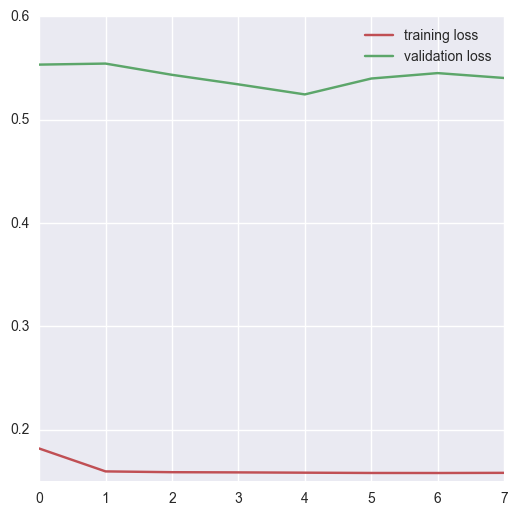

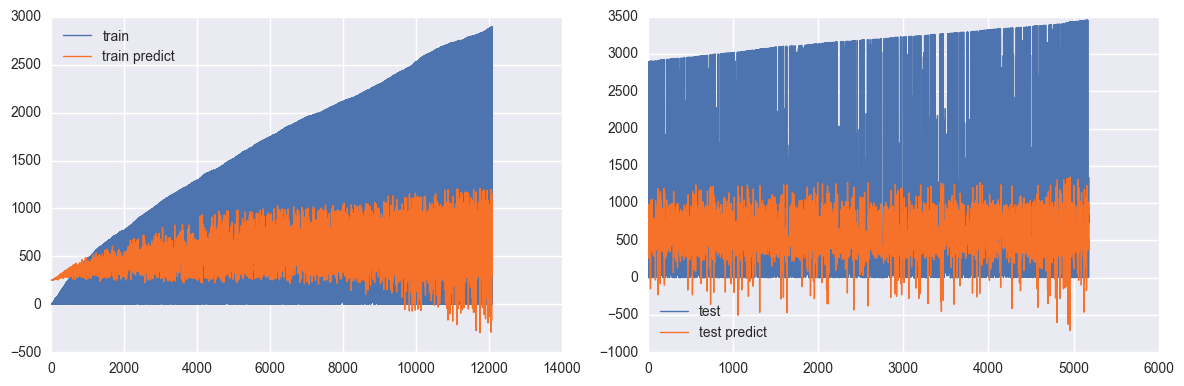

********** TRAINING PREDICTIONS **********
boards make certain make make boards make make certain certain make boards make make certain certain make make make make movable certain make make make certain movable movable certain make make certain movable movable certain make certain certain framework framework certain make certain certain framework framework certain make certain movable sack sack certain make certain movable sack terrible history outhouses outhouses tillers tillers outhouses outhouses tillers tillers tillers tillers tillers heavy lands adjacent adjacent lands heavy heavy heavy adjacent outhouses rough tillers lands weather lands heavy rough history lands paris adjacent heavy adjacent paris carts paris adjacent sheltered weather bespattered rustic rustic rustic rustic mire snuffed snuffed snuffed about snuffed sheltered adjacent rude paris day carts mire snuffed rustic snuffed pigs farmer farmer farmer set set set set farmer set apart apart bespattered carts paris shelter

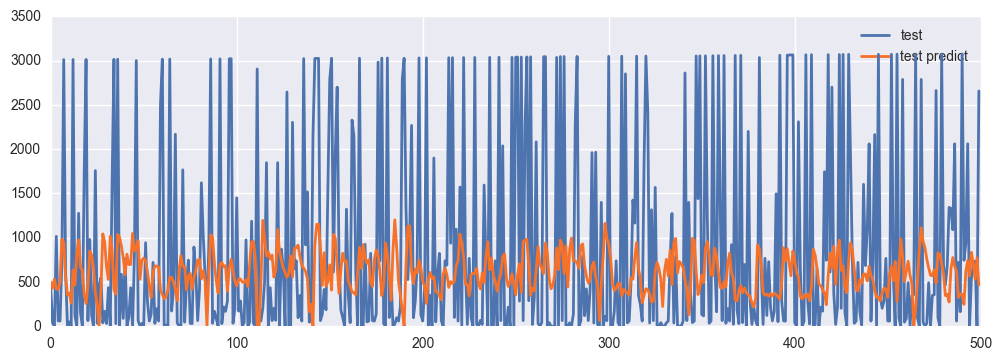

In [19]:
# special case so we can train on the book with just one model and print out the predicted words

word_to_index, index_to_word, book_indices = get_book()

num_epochs = 50  # Early stopping will stop us long before we get this far
training_length = len(book_indices)
units_list = [5]
window_size = 5
linewidth = 1
data_source = 'book'
model_type = 'Dense'

filename = data_source+'-'+model_type+'-units-'+str(units_list)+'-window-'+str(window_size)+'.png'
y_train, y_test = build_and_show(model_type, data_source, units_list=units_list, window_size=window_size, 
               training_length=training_length, epochs=num_epochs, 
               linewidth=linewidth, filename=filename)

# Turn the numericalc predictions into words.
# Clamp prediction to 0 if they're negative - it's all nonsense anyway! 
# (Word 0 is "it")
print('********** TRAINING PREDICTIONS **********')
pos_y_train = [max(v, 0) for v in y_train[0]]
for i in pos_y_train:
    print(index_to_word[int(i)]+' ', end='')
    
print('\n\n\n\n\n********** TEST PREDICTIONS **********')
pos_y_test = [max(v, 0) for v in y_test[0]]
for i in pos_y_test:
    print(index_to_word[int(i)]+' ', end='')
    
# plot a closeup of the start of the test data
zfar = 10
znear = 20
blue_color = '#4d74ae'
orange_color = '#f6712a'
linewidth=2
num_pts = 500
plt.figure(figsize=(12,4))
plt.plot(book_indices[13000:13000+num_pts], label="test", c=blue_color, linewidth=linewidth, zorder=zfar)
plt.plot(pos_y_test[:num_pts], label="test predict", c=orange_color, linewidth=linewidth, zorder=znear)
plt.legend(loc='upper right')
#plt.title('Test, window '+str(window_size)+ ', model Dense[5]')
plt.savefig('book test close-up.png', dpi=300, bbox_inches='tight')
plt.show()